#### *Optimization*

In [83]:
import sys
sys.path.append('../Utils') 
import configs
import numpy as np
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from sklearn.decomposition import PCA
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import (
    accuracy_score, balanced_accuracy_score, f1_score, 
    precision_score, recall_score, classification_report, confusion_matrix
)
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import StandardScaler 
from sklearn.model_selection import cross_val_score
import torch
import torch.nn as nn
from torchvision import models, transforms
from torch.utils.data import DataLoader, Dataset
from torchvision.datasets import ImageFolder

from pathlib import Path
from PIL import Image
from tqdm import tqdm
import pandas as pd
import joblib

In [76]:

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")


Using device: cpu


In [77]:
# ---------------------------
# 1. Multi-View Dataset (optional if using ImageFolder)
# ---------------------------
# If images are already structured by class folders:
train_dataset = ImageFolder(configs.MULTIVIEW_TRAIN_DIR, transform=transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize([0.485,0.456,0.406], [0.229,0.224,0.225])
]))

test_dataset = ImageFolder(configs.MULTIVIEW_TEST_DIR, transform=transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize([0.485,0.456,0.406], [0.229,0.224,0.225])
]))

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True, num_workers=4)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False, num_workers=4)

In [79]:
# ---------------------------
# 2. Feature Extractor (ResNet50, frozen)
# ---------------------------
class FeatureExtractor(nn.Module):
    def __init__(self, backbone="resnet18"):
        super().__init__()
        if backbone=="resnet18":
            model = models.resnet18(weights=models.ResNet18_Weights.DEFAULT)
            self.features = nn.Sequential(*list(model.children())[:-1])
            self.out_dim = model.fc.in_features
        else:
            raise ValueError("Backbone not supported")
        for p in self.parameters():
            p.requires_grad = False

    def forward(self, x):
        with torch.no_grad():
            x = self.features(x)
            x = torch.flatten(x, 1)
        return x

extractor = FeatureExtractor("resnet18").to(device).eval()

In [80]:

# ---------------------------
# 3. Feature Extraction Function
# ---------------------------
def extract_features(loader, model, device):
    model.eval()
    features_list, labels_list = [], []
    with torch.no_grad():
        for imgs, labels in tqdm(loader):
            imgs = imgs.to(device)
            feats = model(imgs)
            features_list.append(feats.cpu().numpy())
            labels_list.append(labels.numpy())
    X = np.vstack(features_list)
    y = np.hstack(labels_list)
    return X, y

In [81]:
train_features, train_labels = extract_features(train_loader, extractor, device)
test_features, test_labels = extract_features(test_loader, extractor, device)
print(f"Train Features: {train_features.shape}, Train Labels: {train_labels.shape}")
print(f"Test Features: {test_features.shape}, Test Labels: {test_labels.shape}")


100%|██████████| 21/21 [00:18<00:00,  1.11it/s]

Train Features: (2785, 512), Train Labels: (2785,)
Test Features: (670, 512), Test Labels: (670,)


In [84]:
# ---------------------------
# 5. Optimized RBF-SVM Pipeline with Grid Search
# ---------------------------
pipeline = Pipeline([
    ('scaler', StandardScaler()),  # redundant if you already scaled, but keeps pipeline flexible
    ('dim_reducer',PCA(n_components=0.95, random_state=42) ),
    ('svm', SVC(class_weight='balanced', probability=True, random_state=42))
])

param_grid = {
    'svm__C': np.logspace(0, 5, 10),         # [1, 3.16, ..., 100000]
    'svm__gamma': np.logspace(-6, -1, 10),   # [1e-6 ... 0.1]
    'svm__kernel': ['rbf']
}

grid_search = GridSearchCV(
    pipeline,
    param_grid,
    cv=5,
    scoring='f1_weighted',
    verbose=2,
    n_jobs=-1
)

grid_search.fit(train_features, train_labels)
print(f"Best Parameters: {grid_search.best_params_}")
best_model = grid_search.best_estimator_



Fitting 5 folds for each of 100 candidates, totalling 500 fits
Best Parameters: {'svm__C': np.float64(3.5938136638046276), 'svm__gamma': np.float64(0.0021544346900318843), 'svm__kernel': 'rbf'}
Best Parameters: {'svm__C': np.float64(3.5938136638046276), 'svm__gamma': np.float64(0.0021544346900318843), 'svm__kernel': 'rbf'}



Optimized RBF-SVM Metrics:
Accuracy: 0.7179
Balanced Accuracy: 0.6705
F1 Score: 0.7133
Precision: 0.7219
Recall: 0.7179
              precision    recall  f1-score   support

         Ash       0.62      0.57      0.60        35
       Beech       0.76      0.83      0.79       160
 Douglas Fir       0.72      0.72      0.72       180
         Oak       1.00      0.40      0.57        20
        Pine       0.90      0.72      0.80        25
     Red Oak       0.70      0.87      0.78        95
      Spruce       0.66      0.58      0.62       155

    accuracy                           0.72       670
   macro avg       0.77      0.67      0.70       670
weighted avg       0.72      0.72      0.71       670



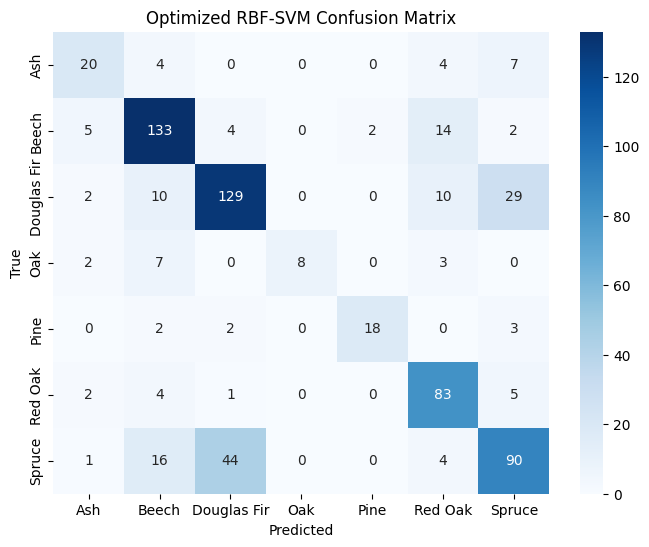

In [85]:
# ---------------------------
# 6. Predictions & Metrics
# ---------------------------
pred_labels = best_model.predict(test_features)

accuracy = accuracy_score(test_labels, pred_labels)
balanced_acc = balanced_accuracy_score(test_labels, pred_labels)
f1 = f1_score(test_labels, pred_labels, average='weighted')
precision = precision_score(test_labels, pred_labels, average='weighted')
recall = recall_score(test_labels, pred_labels, average='weighted')

print("\nOptimized RBF-SVM Metrics:")
print(f"Accuracy: {accuracy:.4f}")
print(f"Balanced Accuracy: {balanced_acc:.4f}")
print(f"F1 Score: {f1:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")

# Classification report
print(classification_report(test_labels, pred_labels, target_names=test_dataset.classes))

# Confusion Matrix
cm = confusion_matrix(test_labels, pred_labels)
plt.figure(figsize=(8,6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=test_dataset.classes, yticklabels=test_dataset.classes)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Optimized RBF-SVM Confusion Matrix')
plt.show()


## Optimization